In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

from collections import OrderedDict


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

# - split data into batches
# - shuffling for dynamically changing fed forwarded data, resulting in diversity
# and ensure closeness to global minima
# (adds complexity by adding diversity ==> reduces overfitting)


**Data Visualization & Analysis**

In [13]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [14]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

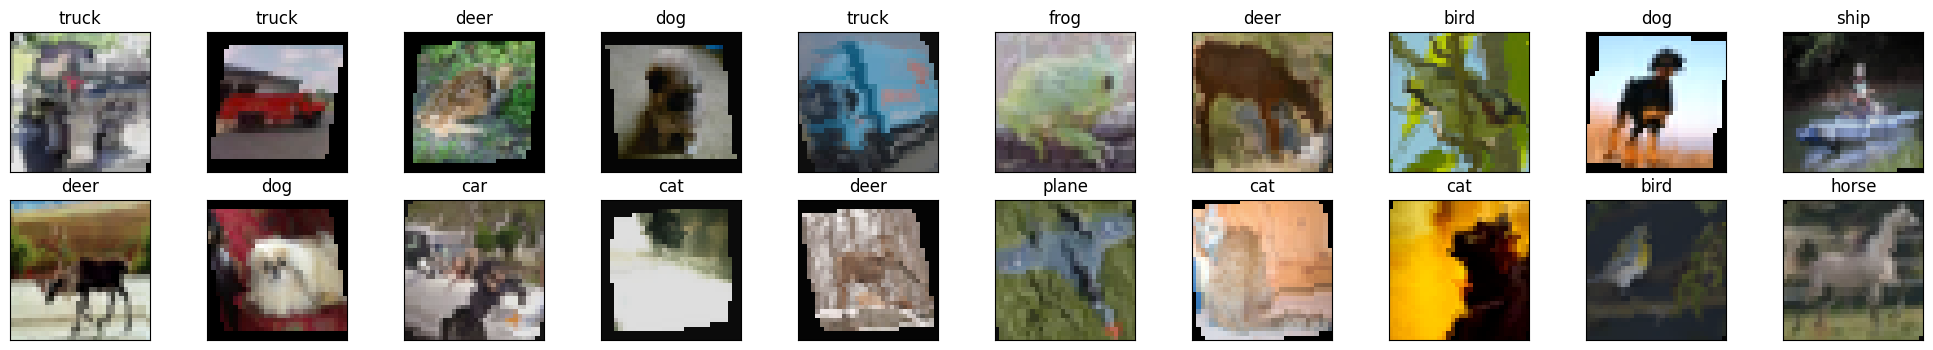

In [15]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

**Constructing Digital Vision NN**

In [16]:
class ConvolutionalDVNN(nn.Module):
  def __init__(self, in_depth, out):
    super().__init__()
    self.conv1 = nn.Conv2d(in_depth, 64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool2d(2, 2)
    self.act = nn.ReLU()

    self.fcn = nn.Sequential(
        OrderedDict([
        ('linear1', nn.Linear(256 * 4 * 4, 500)),
        ('dropout', nn.Dropout(0.5)),
        ('act', nn.ReLU()),
        ('linear2', nn.Linear(500, out)),
    ]))

  def forward(self, x):
    x = self.pool(self.act(self.conv1(x)))
    x = self.pool(self.act(self.conv2(x)))
    x = self.pool(self.act(self.conv3(x)))

    x = x.view(x.size(0), -1)
    x = self.fcn(x)

    """
    The process of Layered Processing <==> Visual Cortex simulation
    """
    return x

In [17]:
model = ConvolutionalDVNN(3, 10).to(device)
criterion = nn.CrossEntropyLoss() #log_softmax + NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

ConvolutionalDVNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (fcn): Sequential(
    (linear1): Linear(in_features=4096, out_features=500, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (act): ReLU()
    (linear2): Linear(in_features=500, out_features=10, bias=True)
  )
)

**Digital Neuroplasticity Process**

In [18]:
epochs = 15
running_loss_history = []
running_accuracy_history = []
val_running_loss_history = []
val_running_accuracy_history = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_running_loss = 0.0
  val_running_accuracy = 0.0

  for images, labels in training_loader:
    inputs = images.to(device)
    labels = labels.to(device)
    scores = model.forward(inputs)

    loss = criterion(scores, labels)
    _, preds = torch.max(scores, 1)
    running_loss += loss.item()
    running_accuracy += torch.sum(preds == labels.data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # Neuroplasticity in action

  else:
    with torch.no_grad():
      for val_images, val_labels in validation_loader:
        val_inputs = val_images.to(device)
        val_labels = val_labels.to(device)
        val_scores = model.forward(val_inputs)

        val_loss = criterion(val_scores, val_labels)
        _, val_preds = torch.max(val_scores, 1)
        val_running_loss += val_loss.item()
        val_running_accuracy += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_accuracy.float()/len(training_loader)
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_accuracy.float()/len(validation_loader)

    running_loss_history.append(epoch_loss)
    running_accuracy_history.append(epoch_acc.cpu())
    val_running_loss_history.append(val_epoch_loss)
    val_running_accuracy_history.append(val_epoch_acc.cpu())

    print(f'Epoch: {e+1} \nTraining/Validation Loss: {epoch_loss:.4f}/{val_epoch_loss:.4}')
    print(f'Training/Validation Accuracy: {epoch_acc:.4f}/{val_epoch_acc:.4f} ')
    print('---------------------------------------------------------------------')



Epoch: 1 
Training/Validation Loss: 1.6060/1.293
Training/Validation Accuracy: 41.0680/53.7700 
---------------------------------------------------------------------
Epoch: 2 
Training/Validation Loss: 1.2466/1.057
Training/Validation Accuracy: 55.4480/62.0600 
---------------------------------------------------------------------
Epoch: 3 
Training/Validation Loss: 1.0814/0.9421
Training/Validation Accuracy: 61.9200/67.4500 
---------------------------------------------------------------------
Epoch: 4 
Training/Validation Loss: 0.9741/0.8851
Training/Validation Accuracy: 65.7220/69.0700 
---------------------------------------------------------------------
Epoch: 5 
Training/Validation Loss: 0.9055/0.8365
Training/Validation Accuracy: 68.4040/70.9800 
---------------------------------------------------------------------
Epoch: 6 
Training/Validation Loss: 0.8520/0.7993
Training/Validation Accuracy: 70.4100/72.5700 
---------------------------------------------------------------------


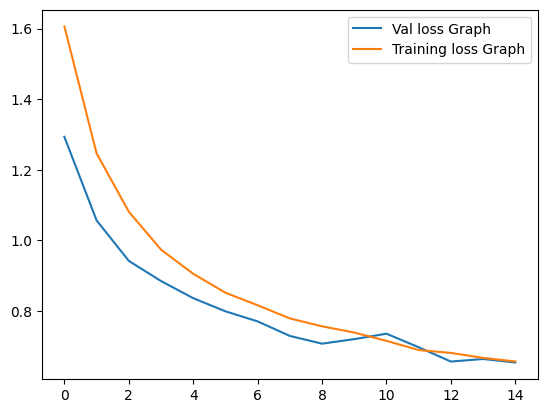

In [46]:
plt.plot(val_running_loss_history, label="Val loss Graph")
plt.plot(running_loss_history, label="Training loss Graph")
plt.legend()

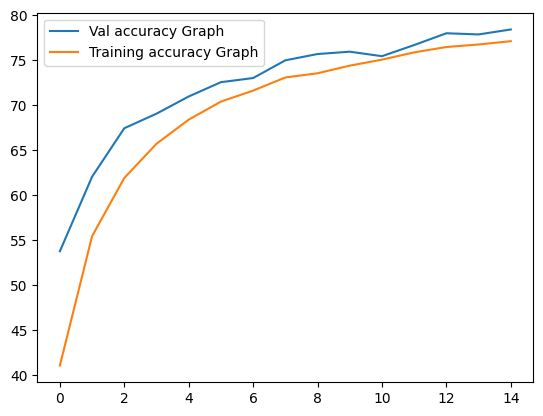

In [47]:
plt.plot(val_running_accuracy_history, label="Val accuracy Graph")
plt.plot(running_accuracy_history, label="Training accuracy Graph")
plt.legend()

**Testing DVNN**

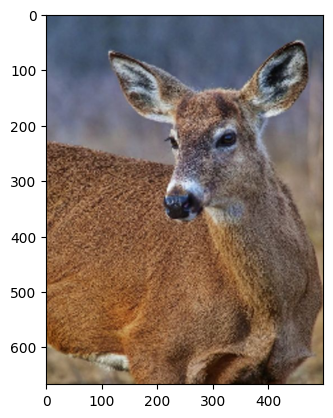

In [39]:
import requests
import PIL.ImageOps
from PIL import Image

url = 'https://imgs.search.brave.com/9t4vYK-cc9Pj0fPYy6MllIvAa99sj_z2iWVzTsxGMOM/rs:fit:500:0:1:0/g:ce/aHR0cHM6Ly9jZG4u/c3RvY2tzbmFwLmlv/L2ltZy10aHVtYnMv/MjgwaC9kZWVyLWFu/aW1hbF9PWUNYOUsz/UUhOLmpwZw'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

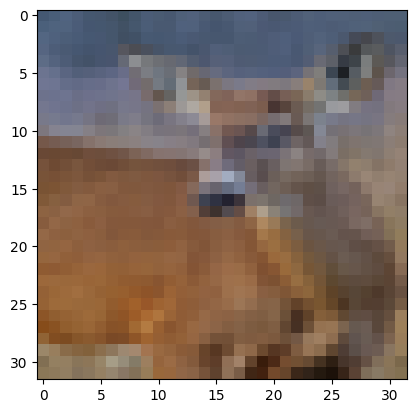

In [41]:
img = transform(img)
plt.imshow(im_convert(img))

In [42]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


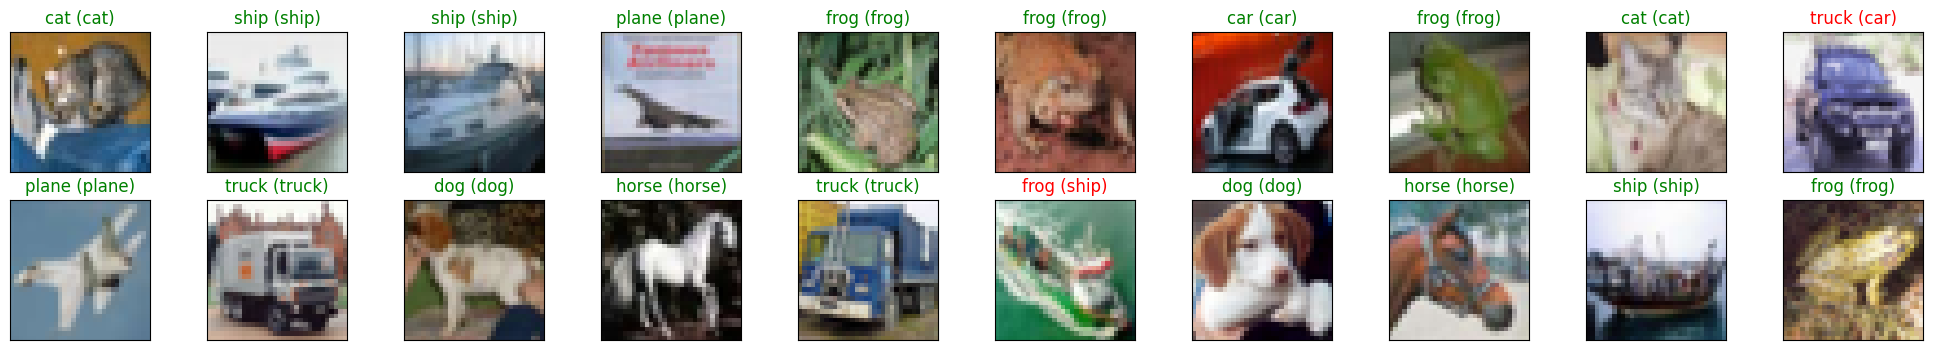

In [45]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

